In [6]:
# %pip install numpy==1.23.5 pandas==1.5.3
%pip install -U matplotlib==3.6.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 8.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 1.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 11.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 1.0 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 2.0 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# attempting spark

In [ ]:
# %pip install pyspark==3.3.1
# need to install java next

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 1.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 172.1 kB/s eta 0:00:0000:01
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845499 sha256=54272e21876125e31df4a9ab51a051822ce20de29308ac76e7999ddb56233447
  Stored in directory: /home/jovyan/.cache/pip/wheels/9c/aa/b1/8433fd8b1afe7eb31196cc74a42cd778bcb52636a428da079d
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [16]:
from pyspark.sql import SparkSession

In [18]:
data_location= "../../cephfs/data/glucose_records_2022-02-01.csv" #only reading 1 day of data
spark=SparkSession.builder.master("local"). \
                           appName('Resd_Glucose_Data'). \
                           getOrCreate()
pyspark_glucose_data=spark.read.csv(data_location, 
                                            header=True,
                                            sep=',')
# return pyspark_glucose_data

JAVA_HOME is not set


RuntimeError: Java gateway process exited before sending its port number

In [ ]:
spark = pyspark.sql.SparkSession\
    .builder \
    .appName(“GlucoseAnalysis) \
    .getOrCreate()
df = spark.read.csv(‘path_to_folder_with_all_csv’, header=True)

# just 1 csv in pandas

### just the very first day

In [ ]:
'''initial read-in of 1 day of data, and saving-out a csv of just the cols we want'''
%time
# usableCols = ["PatientId","GlucoseDisplayTime","Value"]
# df = pd.read_csv(data_location, low_memory=False, usecols=usableCols)
# df.to_csv("../cleanedData/2022-02-01 temp.csv", index=False)
day1 = pd.read_csv("../../cephfs/cleanedData/2022-02-01 temp.csv", parse_dates=['GlucoseDisplayTime'])
day1

In [5]:
day1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1663025 entries, 0 to 1663024
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   PatientId           1663025 non-null  object        
 1   GlucoseDisplayTime  1663025 non-null  datetime64[ns]
 2   Value               1663025 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 38.1+ MB


In [6]:
'''bonus step: dropping any rows where the PatientId or timestamp is missing'''
%time
initRows = day1.shape[0]
day1 = day1.dropna(subset=['PatientId','GlucoseDisplayTime'], how='any')
print(initRows - day1.shape[0], "rows with missing patient ID or timestamp have been removed")

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs
0 rows with missing patient ID or timestamp have been removed


### quick detour for datetime exploration

In [5]:
timestamp = day1['GlucoseDisplayTime'].loc[1]
timestamp

Timestamp('2022-02-01 17:46:26.437000')

In [6]:
print(timestamp.year)
print(timestamp.month)
print(timestamp.day)
print(timestamp.hour)
print(timestamp.minute)
print(timestamp.second)

2022
2
1
17
46
26


### back to EDA

In [ ]:
'''round down to the minute so seconds = 0'''
day1['GlucoseDisplayTime'] = day1['GlucoseDisplayTime'].dt.floor('min') #'min' means 'minute' ('min' can be substituted with 'T' and 'Min' for literally the same effect
day1

next is to change PatientIDs to ints. this is for saving memory space and for our own sanity.

#### read in the cohort data

In [ ]:
'''the index col wasn't removed before saving this csv, so repurpose it to the int ID column'''
cohort = pd.read_csv("../../cephfs/data/cohort.csv")
cohort = cohort.rename(columns={'Unnamed: 0':'intPatientId','UserId':'PatientId'})

'''check for duplicates'''
if len(cohort['intPatientId'].unique()) != len(cohort['PatientId'].unique()) \
    and len(cohort['PatientId'].unique()) != cohort.shape[0]:
    raise NameError("ERROR: duplicate patients found in cohort.csv file")

%time
cohort

probably not worth saving this "cleaned" `cohort` dataframe, since i'm assuming it's more economical to just read in the data and do these two steps when we need it again

In [ ]:
#probably worth adding a function in here that just automatically checks for if any rows are missing data and then deal with that

## replace string IDs with int IDs

next steps: replace 'PatientId' in `day1` dataframe using the key of {'UserId' : 'PatientIdInt'} from `cohort` dataframe
<br>
(not sure if a "merge + drop col + rename col" will be more economical, or if "replace" with dicts will be.)

#### with merge()

In [9]:
day1Merged = day1.merge(cohort[['PatientId','intPatientId']],
                         how = "inner",
                         on = "PatientId") \
        .drop(columns="PatientId") \
        .rename(columns={'intPatientId':'PatientId'})
day1Merged = day1Merged[['PatientId','GlucoseDisplayTime','Value']] #reorder columns for aesthetics
#maybe right merge? it'd eliminate any day1.PatientId's that don't appear in cohort.csv ?
%time
day1Merged

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 10 µs


,PatientId,GlucoseDisplayTime,Value
0,1560,2022-02-01 14:45:00,0
1,1560,2022-02-01 04:15:00,155
2,1560,2022-02-01 06:45:00,114
3,1560,2022-02-01 12:15:00,207
4,1560,2022-01-31 21:30:00,156
...,...,...,...
1663020,3735,2022-02-01 00:21:00,0
1663021,3735,2022-02-01 06:07:00,0
1663022,3735,2022-01-31 21:17:00,0
1663023,3735,2022-01-31 20:51:00,0


In [53]:
'''if day1 took about 8 seconds, round up to 10 seconds for the days with more data and the total time this will take for all 365 CSVs is about (in minutes):'''
10*365/60

60.833333333333336

granted, my 8 sec run was because of like 7.9 seconds of wall time. CPU was miniscule. also the above might be more optimizable (ask katie about this since merge() is SQL based)

#### with replace()

In [54]:
'''this took more than a minute so i didn't even let it finish'''
day1Replaced = day1.replace({'PatientId': idDict})
%time
day1Replaced


KeyboardInterrupt



In [55]:
'''this ALSO took more than a minute so cell killed'''
day1Replaced = day1.replace(idDict)
%time
day1Replaced

KeyboardInterrupt: 

In [56]:
#executing before the next cell so %time will only measure the function i want to measure
day1Replaced = day1.copy()

In [ ]:
'''THIS KILLED THE KERNEL LMAO'''
day1Replaced['PatientId'] = day1Replaced['PatientId'].replace(idDict)
%time
day1Replaced

great news running this answered the question for me.

merge it is.

# multiple days

In [ ]:
#import the patient ID dataframe
%time

'''the index col wasn't removed before saving this csv, so repurpose it to the int ID column'''
cohort = pd.read_csv("../../cephfs/data/cohort.csv")
cohort = cohort.rename(columns={'Unnamed: 0':'intPatientId','UserId':'PatientId'})

'''check for duplicates'''
if len(cohort['intPatientId'].unique()) != len(cohort['PatientId'].unique()) \
    and len(cohort['PatientId'].unique()) != cohort.shape[0]:
    raise NameError("ERROR: duplicate patients found in cohort.csv file")

# cohort.to_csv("../../cephfs/cleanedData/cohort.csv", index=False)
cohort

In [17]:
'''get list of days of the month as strings to cycle through the file locations'''
daysOfTheMonth = {1: 31,
                  2: 28,
                  3: 31,
                  4: 30,
                  5: 30,
                  6: 31,
                  7: 31,
                  8: 31,
                  9: 30,
                  10: 31,
                  11: 30,
                  12: 31}

# for month in range(1,13):
month = 3
daysNumbered = ["01","02","03","04","05","06","07","08","09"]
daysNumbered += [str(i) for i in range(10,daysOfTheMonth[month]+1) ]
daysNumbered

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31']

In [ ]:
#MERGE 'EM, LADS!!!!!!!!
%time

usableCols = ["PatientId","GlucoseDisplayTime","Value"]
dataLocation = "../../cephfs/data/glucose_records_2022-02-"

data = pd.DataFrame(columns=usableCols)

for day in daysNumbered:
    try:
        df = pd.read_csv(dataLocation+day+".csv", low_memory=False, usecols=usableCols, parse_dates=['GlucoseDisplayTime'])
    except:
        continue

    '''bonus step: dropping any rows where the PatientId or timestamp is missing'''
    initRows = df.shape[0]
    df = df.dropna(subset=['PatientId','GlucoseDisplayTime'], how='any')
    print(day, ":", initRows - df.shape[0], "rows with missing patient ID or timestamp have been removed")

    df['GlucoseDisplayTime'] = df['GlucoseDisplayTime'].dt.floor('min') #'min' means 'minute' ('min' can be substituted with 'T' and 'Min' for literally the same effect

    df = df.merge(cohort[['PatientId','intPatientId']],
                             how = "inner",
                             on = "PatientId") \
            .drop(columns="PatientId") \
            .rename(columns={'intPatientId':'PatientId'})
    df = df[['PatientId','GlucoseDisplayTime','Value']] #reorder columns for aesthetics
    #maybe right merge? it'd eliminate any day1.PatientId's that don't appear in cohort.csv ?

    data = pd.concat([data, df], ignore_index=True)

In [2]:
%%time
# data.to_csv("../../cephfs/cleanedData/2022-02 temp.csv", index=False)
data = pd.read_csv("../../cephfs/cleanedData/2022-02 temp.csv", low_memory=False, parse_dates=['GlucoseDisplayTime'])
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49217137 entries, 0 to 49217136
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   PatientId           int64         
 1   GlucoseDisplayTime  datetime64[ns]
 2   Value               int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 GB
CPU times: user 21.9 s, sys: 3.01 s, total: 24.9 s
Wall time: 14min 45s


In [4]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49217137 entries, 0 to 49217136
Data columns (total 3 columns):
 #   Column              Non-Null Count     Dtype         
---  ------              --------------     -----         
 0   PatientId           49217137 non-null  int64         
 1   GlucoseDisplayTime  49217137 non-null  datetime64[ns]
 2   Value               49217137 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 GB


In [12]:
# df = pd.read_csv("../../cephfs/data/glucose_records_2022-04-10.csv", low_memory=False, usecols=usableCols, parse_dates=['GlucoseDisplayTime'])
data['GlucoseDisplayTime'].dt.date.unique()

array([datetime.date(2022, 2, 1), datetime.date(2022, 1, 31),
       datetime.date(2022, 1, 28), datetime.date(2022, 1, 29),
       datetime.date(2022, 1, 30), datetime.date(2022, 1, 23),
       datetime.date(2022, 1, 27), datetime.date(2022, 1, 26),
       datetime.date(2022, 1, 16), datetime.date(2022, 1, 14),
       datetime.date(2022, 1, 21), datetime.date(2022, 1, 11),
       datetime.date(2022, 1, 12), datetime.date(2022, 1, 18),
       datetime.date(2022, 1, 15), datetime.date(2022, 1, 20),
       datetime.date(2022, 1, 25), datetime.date(2022, 1, 24),
       datetime.date(2022, 1, 17), datetime.date(2022, 1, 13),
       datetime.date(2022, 1, 22), datetime.date(2022, 1, 19),
       datetime.date(2022, 1, 10), datetime.date(2022, 2, 2),
       datetime.date(2022, 1, 4), datetime.date(2022, 2, 3),
       datetime.date(2022, 1, 6), datetime.date(2021, 12, 14),
       datetime.date(2021, 11, 23), datetime.date(2022, 2, 4),
       datetime.date(2022, 2, 5), datetime.date(2022, 1, 3)

In [13]:
'''only wanted to do this for the first month (feb 2022) to get rid of jan 2022 and 2021 data'''
data = data[data['GlucoseDisplayTime'].dt.date >= pd.Timestamp(year=2022, month=2, day=1)]
data['GlucoseDisplayTime'].dt.date.unique()

/tmp/ipykernel_219/3753550574.py:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  data = data[data['GlucoseDisplayTime'].dt.date >= pd.Timestamp(year=2022, month=2, day=1)]


array([datetime.date(2022, 2, 1), datetime.date(2022, 2, 2),
       datetime.date(2022, 2, 3), datetime.date(2022, 2, 4),
       datetime.date(2022, 2, 5), datetime.date(2022, 2, 6),
       datetime.date(2022, 2, 7), datetime.date(2022, 2, 8),
       datetime.date(2022, 2, 9), datetime.date(2022, 2, 10),
       datetime.date(2022, 2, 11), datetime.date(2022, 2, 12),
       datetime.date(2022, 2, 13), datetime.date(2022, 2, 14),
       datetime.date(2022, 2, 15), datetime.date(2022, 2, 16),
       datetime.date(2022, 2, 17), datetime.date(2022, 2, 18),
       datetime.date(2022, 2, 19), datetime.date(2022, 2, 20),
       datetime.date(2022, 2, 21), datetime.date(2022, 2, 22),
       datetime.date(2022, 2, 23), datetime.date(2022, 2, 24),
       datetime.date(2022, 2, 25), datetime.date(2022, 2, 26),
       datetime.date(2022, 2, 27), datetime.date(2022, 2, 28),
       datetime.date(2022, 3, 1)], dtype=object)

In [6]:
data

,PatientId,GlucoseDisplayTime,Value
0,1560,2022-02-01 14:45:00,0
1,1560,2022-02-01 04:15:00,155
2,1560,2022-02-01 06:45:00,114
3,1560,2022-02-01 12:15:00,207
4,1560,2022-02-01 01:00:00,187
...,...,...,...
49217132,6463,2022-02-27 10:42:00,169
49217133,6463,2022-02-27 11:02:00,157
49217134,6463,2022-02-27 10:52:00,172
49217135,6463,2022-02-27 10:47:00,171


In [15]:
data.to_csv("../../cephfs/cleanedData/2022-02 temp.csv", index=False)

# 100 patients

## making the sample

### get patients with enough data in february

In [2]:
data = pd.read_csv("../../cephfs/cleanedData/2022-02 temp.csv", low_memory=False, parse_dates=['GlucoseDisplayTime'])

In [3]:
usableValues = data.copy()
usableValues['Value'] = usableValues['Value'].replace(0, np.nan)
usableValues = usableValues[['PatientId','Value']].groupby('PatientId').count().reset_index()
usableValues = usableValues[usableValues['Value']>=6452]
usableValues

,PatientId,Value
0,0,7917
5,7,7355
6,9,7913
7,11,7769
8,12,6818
...,...,...
6902,7990,7234
6903,7993,7667
6905,7997,7576
6906,7998,7464


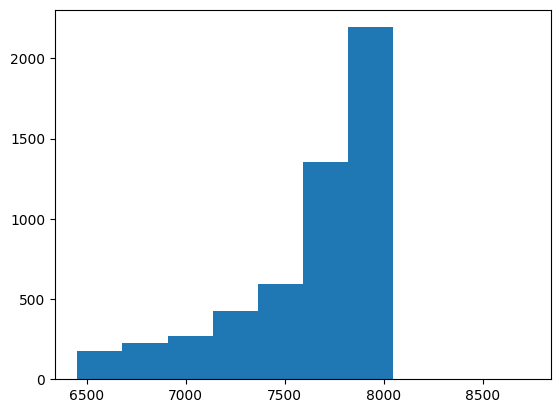

In [10]:
plt.hist(usableValues['Value'], bins=10)
plt.show()

In [11]:
del data
28*(60/5)*24 * 0.80

6451.200000000001

### back to the cohort data

In [5]:
cohort = pd.read_csv("../../cephfs/cleanedData/cohort.csv")
cohort

,intPatientId,PatientId,Gender,DOB,Age,DiabetesType,Treatment
0,0,5lZPrCk6qk8L6Jw+SU+NYDjP2u3hF6JNASttkRUi6Vc=,Female,1931-01-01,92,type-two,no
1,1,9qY9mZ+GV5Kd/O/NB1FuD4JqCUg2etZvhhFLwGTZfbY=,Male,1937-01-01,86,type-two,no
2,2,uhsyLhr4Zl6NfGbNBOXBvLo6ZD9OnFVF297de5/SrfE=,Female,1938-01-01,85,type-two,no
3,3,9uAVHBOgoCJ9hfcrLJvRxkwT/VpWZOFZ5iqAtRY3YH8=,Male,1938-01-01,85,type-two,no
4,4,Fyb156jU1edGykL7NCQBK+uTMpT7hNkq+/H1wwG1eeE=,Female,1939-01-01,84,type-two,no
...,...,...,...,...,...,...,...
7995,7995,y7iPpTOpOsK0Xx8V6oNYmyrhB5XclbVy7vNRugo2YH0=,Female,1992-01-01,31,type-two,yes-long-acting
7996,7996,KbLjey5zQXaIFNFgconzI5c9FJtIpzPR36YzWVICmpM=,Female,1993-01-01,30,type-two,yes-long-acting
7997,7997,JKatRtvvKlFbWRE7ewo4vaFM8c2HST13KhVKOZ7oz9U=,Female,1993-01-01,30,type-two,yes-long-acting
7998,7998,saW1uk+rYwjh90Jv26OS65cgJsY6LXs90C4tt0oGXWQ=,Female,1993-01-01,30,type-two,yes-long-acting


In [6]:
cohort['AgeBin'] = "age>=90"

ageRanges = np.linspace(30,90,7, dtype=int)
for i in range(0,len(ageRanges)-1):
        cohort.loc[(cohort['Age']>=ageRanges[i]) & (cohort['Age']<ageRanges[i+1]), 'AgeBin'] = "%i<=age<%i"%(ageRanges[i],ageRanges[i+1])

In [7]:
cols = ['Gender','Treatment','AgeBin']

for c in cols:
    temp = cohort[[c,'PatientId']] \
                .groupby(c) \
                .count() \
                .rename(columns={'PatientId':'how many to sample'}) \
                /8000*100
    print(temp.round(0))
print("round age>=90 up to 1")

        how many to sample
Gender                    
Female                50.0
Male                  50.0
                 how many to sample
Treatment                          
no                             15.0
yes-both                       61.0
yes-fast-acting                 9.0
yes-long-acting                15.0
            how many to sample
AgeBin                        
30<=age<40                 6.0
40<=age<50                19.0
50<=age<60                25.0
60<=age<70                25.0
70<=age<80                20.0
80<=age<90                 4.0
age>=90                    0.0
round age>=90 up to 1


In [8]:
cohortSample = cohort[cohort['intPatientId'].isin(usableValues['PatientId'].values)]
cohortSample = cohortSample.sample(n=100, random_state=4)
cohortSample = cohortSample.drop(index=[300, 301, 1358, 6961])
cohortSample = pd.concat([cohortSample, cohort.iloc[[7930, 7934, 6786, 7916]]])

for c in cols:
    temp = cohortSample[[c,'PatientId']].groupby(c).count() \
                .rename(columns={'PatientId':'number sampled'})
    print(temp)

        number sampled
Gender                
Female              50
Male                50
                 number sampled
Treatment                      
no                           15
yes-both                     61
yes-fast-acting               9
yes-long-acting              15
            number sampled
AgeBin                    
30<=age<40               6
40<=age<50              19
50<=age<60              25
60<=age<70              25
70<=age<80              20
80<=age<90               4
age>=90                  1


In [9]:
cohortSample.to_csv("../../cephfs/cleanedData/cohortSample.csv", index=False)

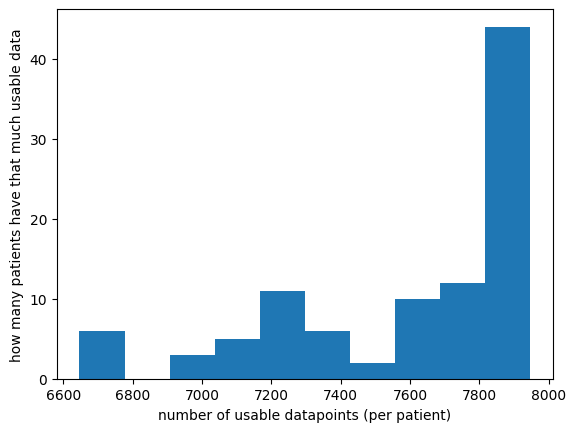

In [17]:
temp = cohortSample.merge(usableValues, how="inner", left_on="intPatientId", right_on="PatientId")
plt.hist(temp['Value'], bins=10)
plt.xlabel("number of usable datapoints (per patient)")
plt.ylabel("how many patients have that much usable data")
del temp

## loading in the sample

In [2]:
cohort = pd.read_csv("../../cephfs/cleanedData/cohortSample.csv")
cohort

,intPatientId,PatientId,Gender,DOB,Age,DiabetesType,Treatment,AgeBin
0,2679,zO0O4PEQk5BCbgIEzmsf0+rXSJW0GeVnc1YD1woeRjQ=,Male,1954-01-01,69,type-two,yes-both,60<=age<70
1,4380,NfA52wm2uXH6ylO7t8cLa6HOuitp5A7SMcSqsEgkLRs=,Female,1968-01-01,55,type-two,yes-both,50<=age<60
2,6771,iyj3cCYZzfG+qkfcXvYoHBGQDR1YQaNyquFzw/Asf8k=,Male,1987-01-01,36,type-two,yes-fast-acting,30<=age<40
3,6635,kCUQmF/dxRedNzfzoKbE1KV+ykWQfuD333YBo6+mKLA=,Male,1974-01-01,49,type-two,yes-fast-acting,40<=age<50
4,1526,gB7wpTCcCPfshcUxBsYJdvvgq9FCw6jB8JWNrx2nlJ8=,Male,1944-01-01,79,type-two,yes-both,70<=age<80
...,...,...,...,...,...,...,...,...
95,834,Fu6b6aYEAlF/0wUK5z8S99RpVAaKLnle+SnLjk+Wsjc=,Male,1976-01-01,47,type-two,no,40<=age<50
96,7930,vLUyKuCEq/HvT/IWXWDXxuXFmSL87mieU6PAjs+wxtU=,Male,1984-01-01,39,type-two,yes-long-acting,30<=age<40
97,7934,Exe9vH/aXLaJD6abcJsPfmgBAMgGkGidAVvzLDjRi+g=,Female,1984-01-01,39,type-two,yes-long-acting,30<=age<40
98,6786,LpMi9OU0faxGIBvINEdcuy81vIi+bpTahjuA1EgzYLY=,Male,1931-01-01,92,type-two,yes-long-acting,age>=90


In [3]:
data = pd.read_csv("../../cephfs/cleanedData/2022-02 temp.csv", low_memory=False, parse_dates=['GlucoseDisplayTime'])

In [4]:
data = data[data['PatientId'].isin(cohort['intPatientId'].values)]
data

,PatientId,GlucoseDisplayTime,Value
800,7161,2022-02-01 17:49:00,0
801,7161,2022-02-01 17:38:00,0
802,7161,2022-02-01 08:48:00,198
803,7161,2022-02-01 02:23:00,198
804,7161,2022-02-01 16:23:00,193
...,...,...,...
49211736,3203,2022-02-28 11:16:00,0
49211737,3203,2022-02-28 11:36:00,0
49211738,3203,2022-02-28 06:56:00,0
49211739,3203,2022-02-27 20:21:00,0


In [5]:
data.to_csv("../../cephfs/cleanedData/2022-02 sample.csv", index=False)